In [51]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import cv2
import sys
import selectivesearch
from skimage.filters import gaussian
from sklearn import preprocessing
import scipy.misc
import imageio

sys.path.append(r"D:\Projects\LEGO Vision\Helpers")
import helpers

In [1]:
def resize_and_pad(img, width, height, pad_value=114):
    img_width = len(img[0])
    img_height = len(img)
    scale_w = img_width > img_height
    target_w = width
    target_h = height

    if scale_w:
        target_h = int(np.round(img_height * float(width) / float(img_width)))
    else:
        target_w = int(np.round(img_width * float(height) / float(img_height)))

    resized = cv2.resize(img, (target_w, target_h), 0, 0, interpolation=cv2.INTER_NEAREST)

    top = int(max(0, np.round((height - target_h) / 2)))
    left = int(max(0, np.round((width - target_w) / 2)))
    bottom = height - top - target_h
    right = width - left - target_w
    resized_with_pad = cv2.copyMakeBorder(resized, top, bottom, left, right,
                                          cv2.BORDER_CONSTANT, value=[pad_value, pad_value, pad_value])

    # transpose(2,0,1) converts the image to the HWC format which CNTK accepts
    model_arg_rep = np.ascontiguousarray(np.array(resized_with_pad, dtype=np.float32).transpose(2, 0, 1))

    dims = (width, height, target_w, target_h, img_width, img_height)
    return resized_with_pad, model_arg_rep, dims

In [39]:
img = cv2.imread(r"D:\LEGO Vision Datasets\Detection\Natural Data_output\testImages\IMG_20181105_092359.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = helpers.image_resize(img, width=1440)
# img = resize_and_pad(img, width=1440, height=1440)[0]

In [9]:
# import the necessary packages
import numpy as np
 
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes	
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
 
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
 
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

In [40]:
%%time
labels, regions = selectivesearch.selective_search(img, scale=500, sigma=1.5, min_size=600)

Wall time: 19 s


In [41]:
def from_size_to_coordinates(box):
    x1, y1 = box[:2]
    x2, y2 = box[:2] + box[2:]
    return x1, y1, x2, y2

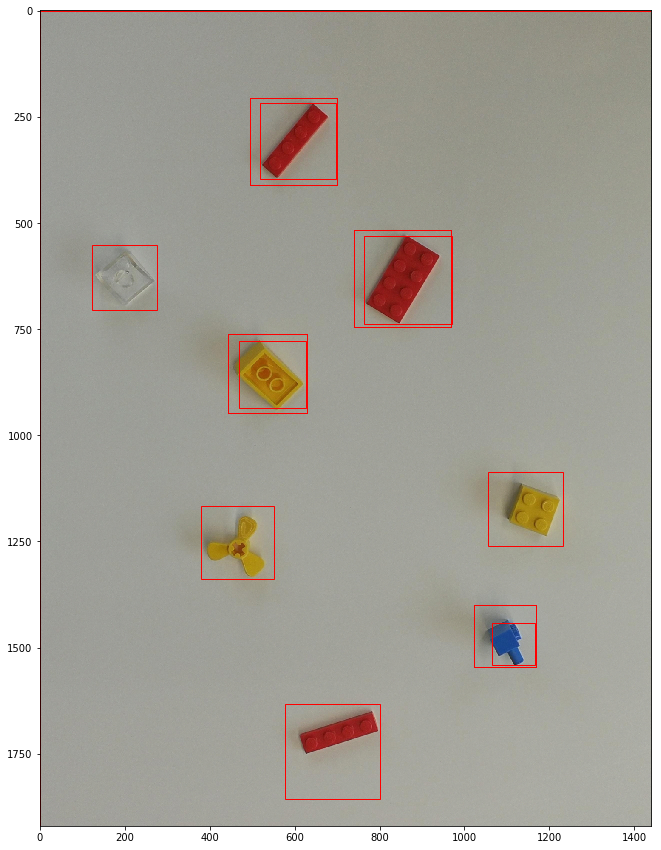

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
ax.imshow(img)
for x1, y1, x2, y2 in map(lambda x: from_size_to_coordinates(np.asarray(x['rect'])), regions):
    w = abs(x2 - x1)
    h = abs(y2 - y1)
    if h > w:
        window_size = h
    else:
        window_size = w
    rect = mpatches.Rectangle((x1, y1), window_size, window_size, fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)   
plt.show()

In [43]:
def from_size_to_coordinates(box):
    x1, y1 = box[:2]
    x2, y2 = box[:2] + box[2:]
    return x1, y1, x2, y2

In [44]:
bboxes_before_nms = []
for bbox in map(lambda x: np.asarray(x['rect']), regions):
    if bbox[2] > 400 or bbox[3] > 400:
        continue
    bboxes_before_nms.append(from_size_to_coordinates(bbox))
bboxes_after_nms = non_max_suppression_fast(boxes=np.asarray(bboxes_before_nms), overlapThresh=0.1)
print(bboxes_after_nms)

[[ 578 1633  802 1763]
 [1022 1399 1142 1545]
 [ 380 1166  536 1338]
 [1056 1086 1231 1250]
 [ 443  762  629  948]
 [ 740  516  949  745]
 [ 122  552  273  705]
 [ 496  205  686  410]]


In [45]:
from sklearn.externals import joblib
classifier = joblib.load(r"D:\Projects\LEGO Vision\Classification\Final models\SVM\SVM-3200-256W.joblib")
shape = (256, 256)

In [55]:
classifier = joblib.load(r"D:\Projects\LEGO Vision\Classification\Final models\SVM\SVM-3200-128W.joblib")
shape = (128, 128)

In [53]:
label_lookup = ['2458-blue', '3003-yellow', '3020-red', '3039-trans-clear', '3298-yellow', '3710-red',
                '6041-yellow']

In [52]:
from sklearn import preprocessing
def classify(ax, classifier, red_block, x, y):
    preproccesed = helpers.pipeline(red_block, shape=shape, smoothing=0.1, with_hog_attached=True,
                                    with_dominant_color_attached=True, pixels_per_cell=(shape[0]/8, shape[0]/8),
                                    cells_per_block=(8, 8), debug=False)
    preproccesed = preprocessing.scale(preproccesed, with_mean=False)          
    
    prediction = classifier.predict_proba([preproccesed])[0]
    ax.annotate(f"{label_lookup[np.argmax(prediction)]} {max(prediction) * 100:.2f}%", (x, y))

Used shape: (128, 128)


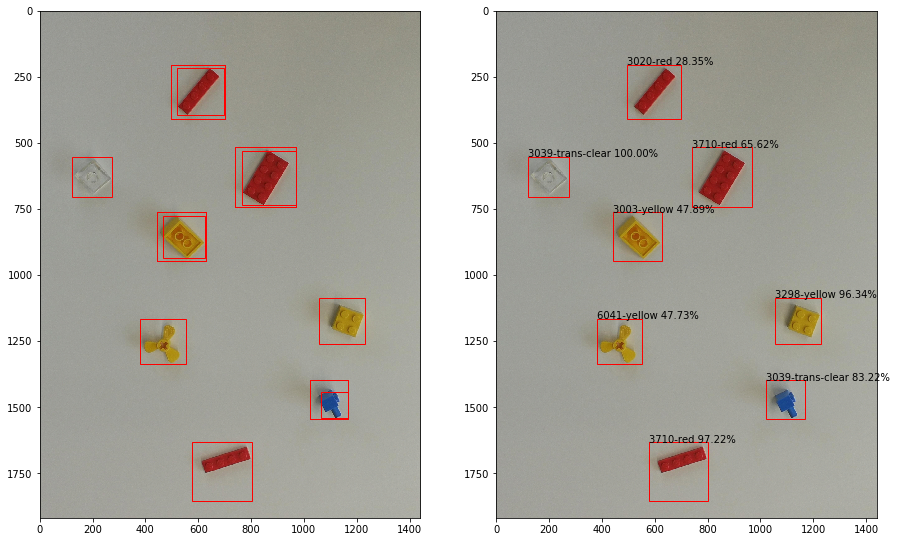

In [56]:
print(f"Used shape: {shape}")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,30))
axs[0].imshow(img)
for x1, y1, x2, y2 in bboxes_before_nms:
    w = abs(x2 - x1)
    h = abs(y2 - y1)
    if h > w:
        window_size = h
    else:
        window_size = w
    rect = mpatches.Rectangle((x1, y1), window_size, window_size, fill=False, edgecolor='red', linewidth=1)
    axs[0].add_patch(rect)
    
axs[1].imshow(img)
for x1, y1, x2, y2 in bboxes_after_nms:
    w = abs(x2 - x1)
    h = abs(y2 - y1)
    if h > w:
        window_size = h
    else:
        window_size = w
    rect = mpatches.Rectangle((x1, y1), window_size, window_size, fill=False, edgecolor='red', linewidth=1)
    axs[1].add_patch(rect)
    sub_image = img[y1:y1 + window_size, x1:x1 + window_size, :]  
    preproccesed = helpers.pipeline(sub_image, shape=shape, smoothing=0.1, with_hog_attached=True,
                                    with_dominant_color_attached=True, pixels_per_cell=(shape[0]/8, shape[0]/8),
                                    cells_per_block=(8, 8), debug=False)
    preproccesed = preprocessing.scale(preproccesed, with_mean=False)      
    prediction = classifier.predict_proba([preproccesed])[0]
    if max(prediction) < 0.97:        
        image_array = img[y1 - int(window_size*0.50):y1 + int(window_size*1.50), x1 - int(window_size*0.50):x1 + int(window_size*1.50), :]
        imageio.imwrite(f'{label_lookup[np.argmax(prediction)]}.jpg', image_array)
    classify(axs[1], classifier, sub_image, x1, y1)
    
plt.show()